# Анализ рейтинга ноутбуков

**Цель:** мы хотим выпустить ноутбук, но для этого нужно понимать оптимальные параметры для него. Следовательно, основываясь на пользовательском рейтинге, нам нужно выбрать оптимальную ОС, размер хранилища и т. п.

**Гипотеза:** если мы выпустим ноутбук с наиболее востребованными характеристиками, то он будет лучше продаваться.

## Описание данных

[Ссылка на источник](https://www.kaggle.com/datasets/rajugc/laptop-selection-dataset)

Этот набор данных содержит информацию о 1000 ноутбуках, доступных на индийском интернет-магазине Flipkart. Данные включают технические характеристики, такие как тип процессора, размер ОЗУ, ёмкость жёсткого диска, размер и разрешение экрана, а также операционная система. Кроме того, в наборе данных содержатся оценки и отзывы пользователей, а также информация о ценах. Набор данных предоставляет комплексный обзор рынка ноутбуков в Индии и может быть использован для анализа, исследований или других целей. Этот набор данных является ценным ресурсом для студентов, профессионалов и обычных пользователей, которые ищут ноутбук в Индии.

## Загрузка данных

In [1]:
import re
import pandas as pd
import seaborn as sns
import missingno as msno
from phik import phik_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("D:\ds\mipt\laptops.csv")

## Предобработка

In [4]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*39)
    print('Пропусков в колонках:')
    missing_counts = dataframe.isna().sum()
    percentage_missing = (missing_counts / dataframe.shape[0]) * 100
    print(pd.concat([missing_counts, percentage_missing.round(1)], 
                    axis=1, keys=['Количество', 'Доля, %']))

def get_uniques(dataframe):
    columns = dataframe.columns
    uniques = [dataframe[col].dropna().unique().tolist() for col in columns]
    data_types = [dataframe[col].dtype for col in columns]
    result_df = pd.DataFrame(
        {'Столбцы': columns,
         'Уникальные значения': uniques, 
         'Тип данных': data_types})
    return result_df

In [5]:
prep(df)
get_info(df)

,Unnamed: 0,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,0,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo Intel Core i5 11th Gen,62990,Intel Core i5 Processor (11th Gen),16 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.5,14.0,1.0
1,1,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo V15 G2 Core i3 11th Gen,37500,Intel Core i3 Processor (11th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,1 TB HDD|256 GB SSD,15.6,4.4,53.0,3.0
2,2,https://rukminim1.flixcart.com/image/312/312/l...,ASUS TUF Gaming F15 Core i5 10th Gen,49990,Intel Core i5 Processor (10th Gen),8 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.4,4733.0,463.0
3,3,https://rukminim1.flixcart.com/image/312/312/x...,ASUS VivoBook 15 (2022) Core i3 10th Gen,33990,Intel Core i3 Processor (10th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,15.6,4.3,10406.0,1040.0
4,4,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo Athlon Dual Core,18990,AMD Athlon Dual Core Processor,4 GB DDR4 RAM,DOS Operating System,256 GB SSD,14.0,3.8,18.0,3.0


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        984 non-null    int64  
 1   img_link          984 non-null    object 
 2   name              984 non-null    object 
 3   price(in Rs.)     984 non-null    int64  
 4   processor         984 non-null    object 
 5   ram               984 non-null    object 
 6   os                984 non-null    object 
 7   storage           984 non-null    object 
 8   display(in inch)  984 non-null    float64
 9   rating            688 non-null    float64
 10  no_of_ratings     688 non-null    float64
 11  no_of_reviews     688 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 92.4+ KB
**************************************************
Явных дубликатов: 0
***************************************
Пропусков в 

Типы данных в порядке, но 30% позиций в наборе не имеют данных про оценки и количество ревью, что является целевым признаком. Многовато. Поищем с чем это может быть связано.

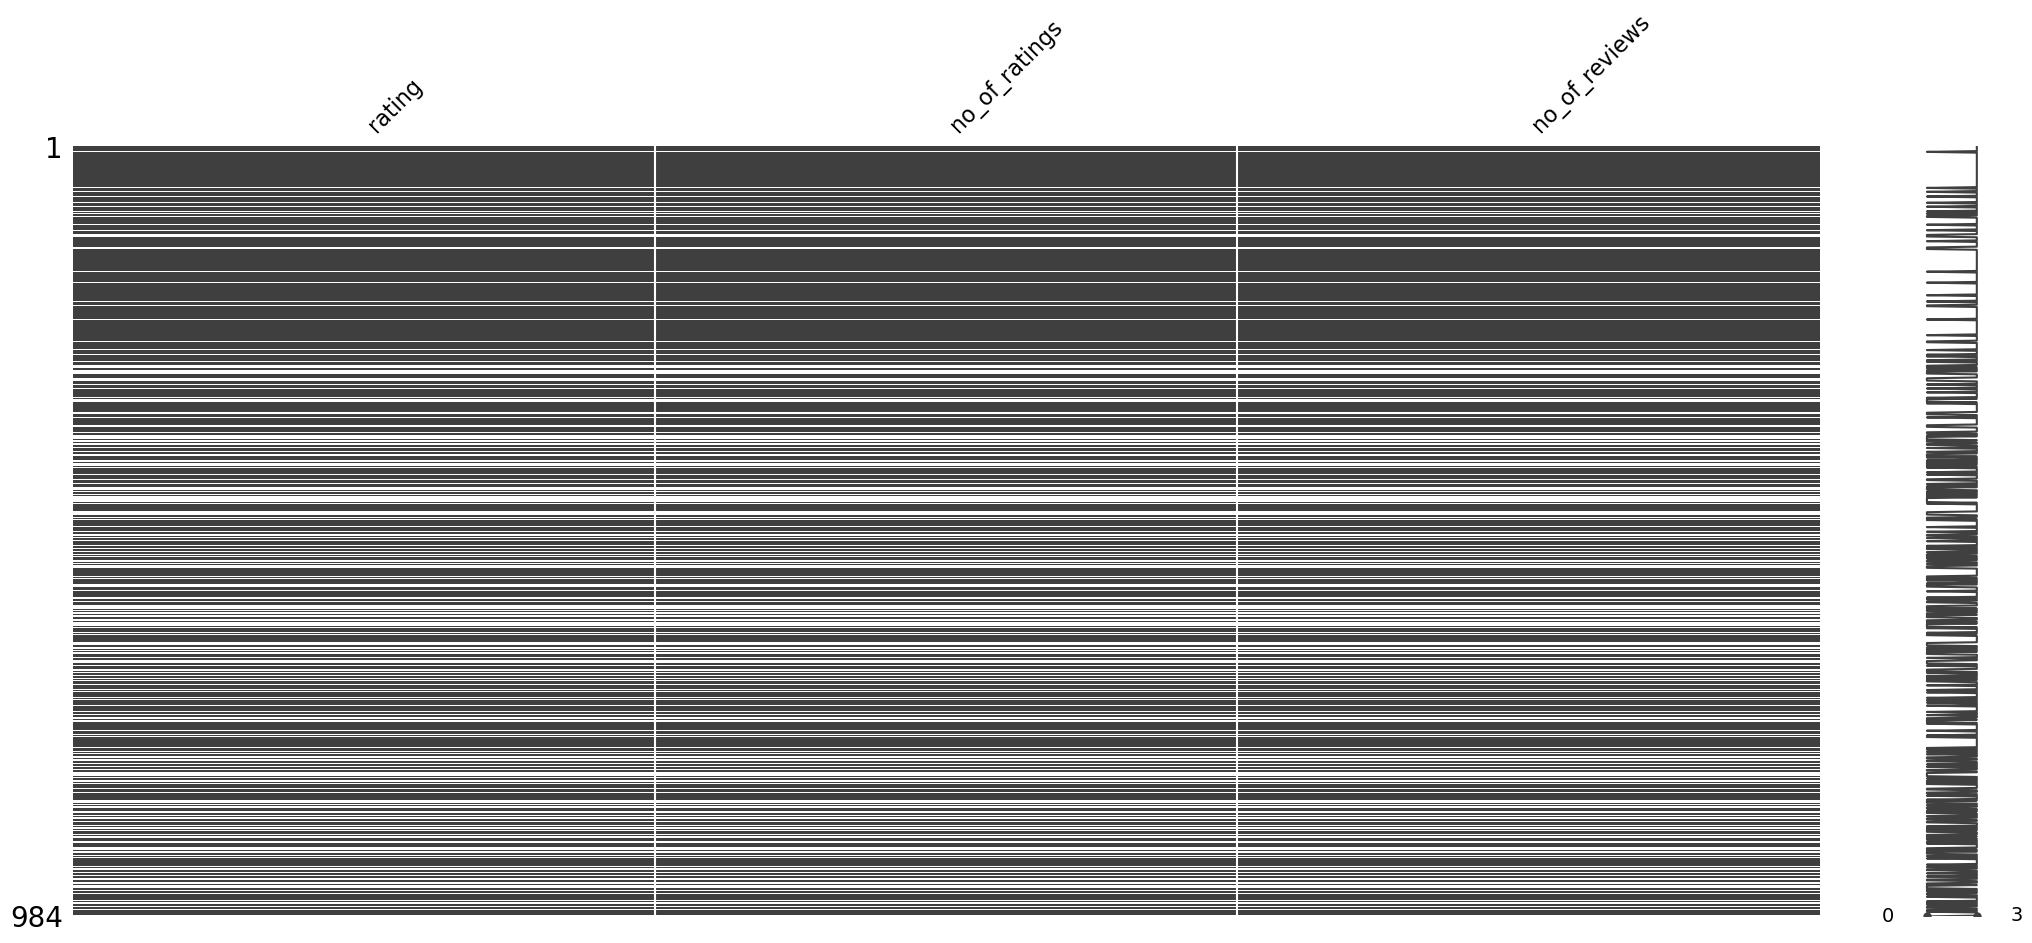

In [6]:
df = df.drop(columns=['Unnamed: 0', 'img_link'])

df_subset = df[['rating', 'no_of_ratings', 'no_of_reviews']]
msno.matrix(df_subset)
plt.show()

В целом пропуски достаточно равномерно и бессистемно распределены по датасету. Логично, что структура пропусков у этих трёх столбцов абсолютно одинаковая.

In [7]:
df['rating_na'] = df['rating'].isnull().astype(int)
columns = ['processor', 'ram', 'os', 'storage']

for col in columns:
    print(
        df.groupby(col)['rating_na']
        .mean()
        .sort_values(
            ascending=False)
            .head(10)
        )

processor
AMD Ryzen 7 Octa Core Processor (4th Gen)       1.0
AMD Ryzen 5 Hexa Core Processor (10th Gen)      1.0
Intel Core i7 Processor (13th Gen)              1.0
Apple M2 Pro Processor                          1.0
AMD Ryzen 9 Octa Core Processor (9th Gen)       1.0
Intel Core i9 Processor (13th Gen)              1.0
AMD Ryzen 7 Octa Core Processor (5th Gen)       1.0
Intel Core i7 Processor (6th Gen)               1.0
Intel Celeron Dual Core Processor (10th Gen)    1.0
Intel Pentium Quad Core Processor (11th Gen)    1.0
Name: rating_na, dtype: float64
ram
32 GB LPDDR4X RAM           1.000000
16 GB LPDDR4 RAM            1.000000
32 GB DDR5 RAM              0.904762
32 GB LPDDR5 RAM            0.800000
16 GB LPDDR3 RAM            0.800000
8 GB DDR5 RAM               0.750000
16 GB DDR5 RAM              0.666667
16 GB Unified Memory RAM    0.615385
16 GB LPDDR5 RAM            0.590909
32 GB DDR4 RAM              0.571429
Name: rating_na, dtype: float64
os
Windows 11 Operating System  

Итак, у нас полностью нет информации о рейтингах некоторых процессоров, в остальном какую-то системность в пропусках выявить не удалось. Оставляю пропуски без изменений.

## Исследовательский анализ

Посмотрим на представленные бренды.

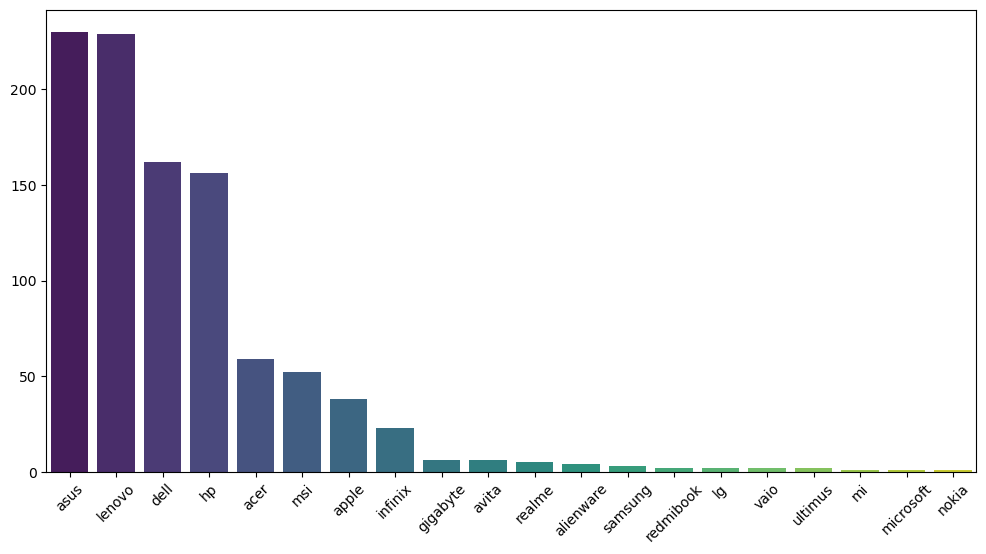

In [ ]:
df['vendor'] = df['name'].str.split().str[0].str.lower()
vendor_counts = df['vendor'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=vendor_counts.index, y=vendor_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.show()

Подавляющее большинство моделей - это всего 4 бренда: Asus, Lenovo, Dell и HP. Посмотрим на распределение по цене.

count       984.000000
mean      80960.720528
std       57421.220919
min       15990.000000
25%       42655.000000
50%       62990.000000
75%       94990.000000
max      419990.000000
Name: price(in Rs.), dtype: float64


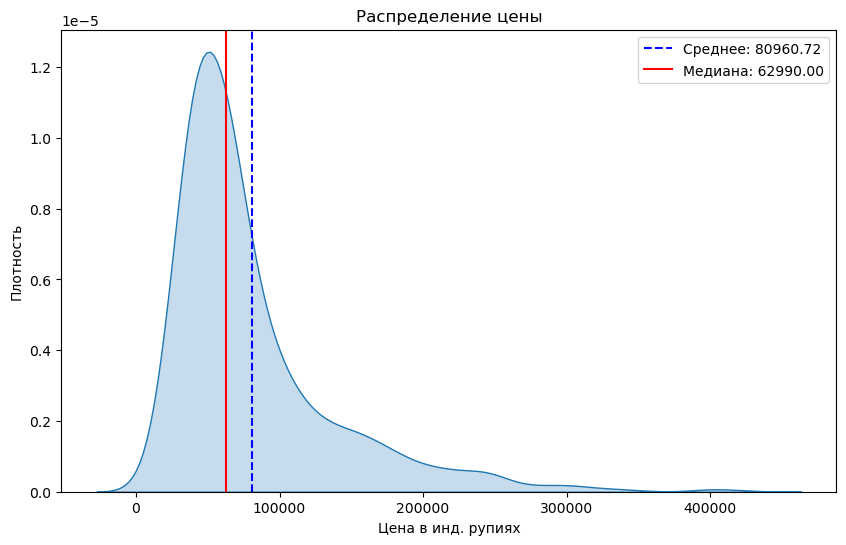

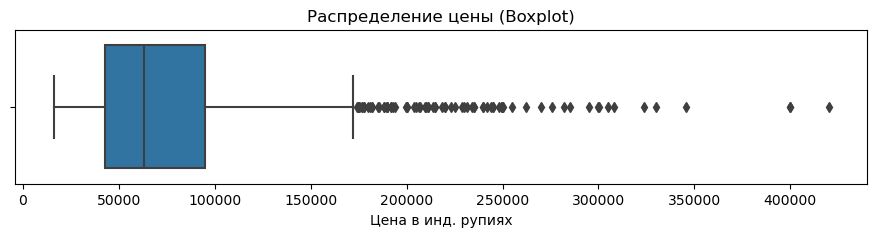

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['price(in Rs.)'], fill=True)

mean_price = df['price(in Rs.)'].mean()
median_price = df['price(in Rs.)'].median()

plt.axvline(
    mean_price, 
    color='blue', 
    linestyle='--', 
    label=f'Среднее: {mean_price:.2f}'
)
plt.axvline(
    median_price, 
    color='red', 
    linestyle='-', 
    label=f'Медиана: {median_price:.2f}'
)
plt.xlabel("Цена в инд. рупиях")
plt.ylabel("Плотность")
plt.title("Распределение цены")
plt.legend() 

plt.figure(figsize=(11, 2))
sns.boxplot(x=df['price(in Rs.)'])
plt.xlabel("Цена в инд. рупиях")
plt.title("Распределение цены (Boxplot)")

print(df['price(in Rs.)'].describe())
plt.show()

Наиболее характерная цена (50% средних значений) - от 42655 до 94990 рупий. Среднее значение 80960 сдвинуто вправо относительно медианного 62990 засчёт хвоста в правой части распределения. Выбросы начинаеются примерно от 175000 рупий, наиболее выдающиеся нехарактерные значения начинаются примерно от 325000.

Посмотрим на категориальные признаки. Можно попробовать рассчитать корреляцию методом Phik.

interval columns not set, guessing: ['rating', 'display(in inch)']


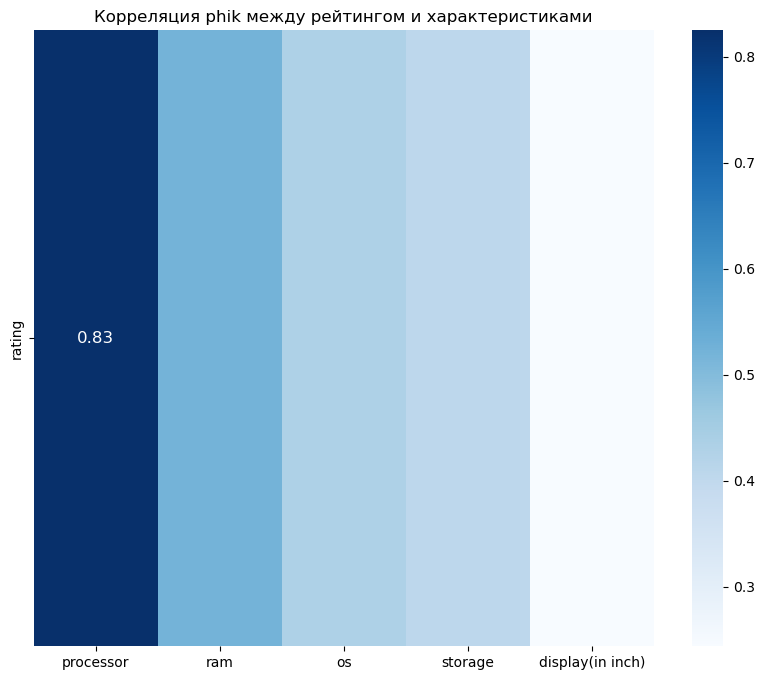

In [10]:
phik_matrix = df[
    [
        'processor', 
        'rating', 
        'ram', 
        'os', 
        'storage', 
        'display(in inch)'
    ]
].phik_matrix()

plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    phik_matrix.loc[
        ['rating'], [
            'processor', 
            'ram', 
            'os', 
            'storage', 
            'display(in inch)'
            ]
        ],
    annot=True, 
    cmap="Blues", 
    fmt=".2f",  
    cbar=True, 
    annot_kws={
        "size": 12, 
        "ha": "center", 
        "va": "center"
        }
    )
plt.title("Корреляция phik между рейтингом и характеристиками")
plt.show()

Матрица говорит, что в первую очередь на рейтинг будет влиять тип процессора и объём RAM. Далее поcмотрим на распределение рейтинга для самых популярных конфигураций. Нас интересуют наиболее актуальные варианты (в контексте этого датасета), поэтому просто возьмём топ-10 по частоте встречаемости в наборе.

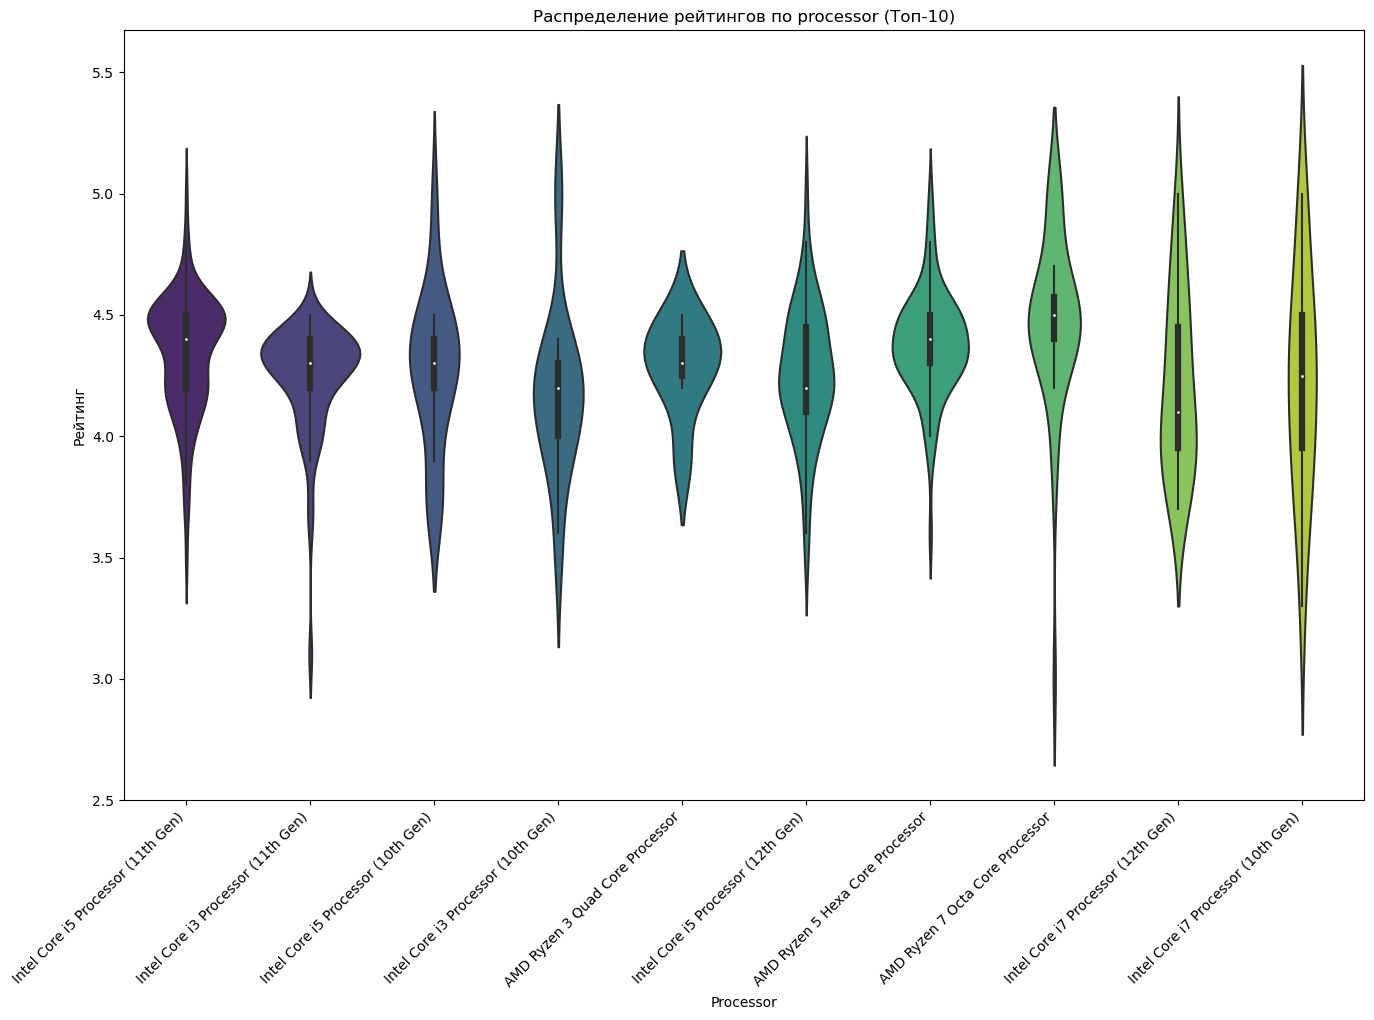

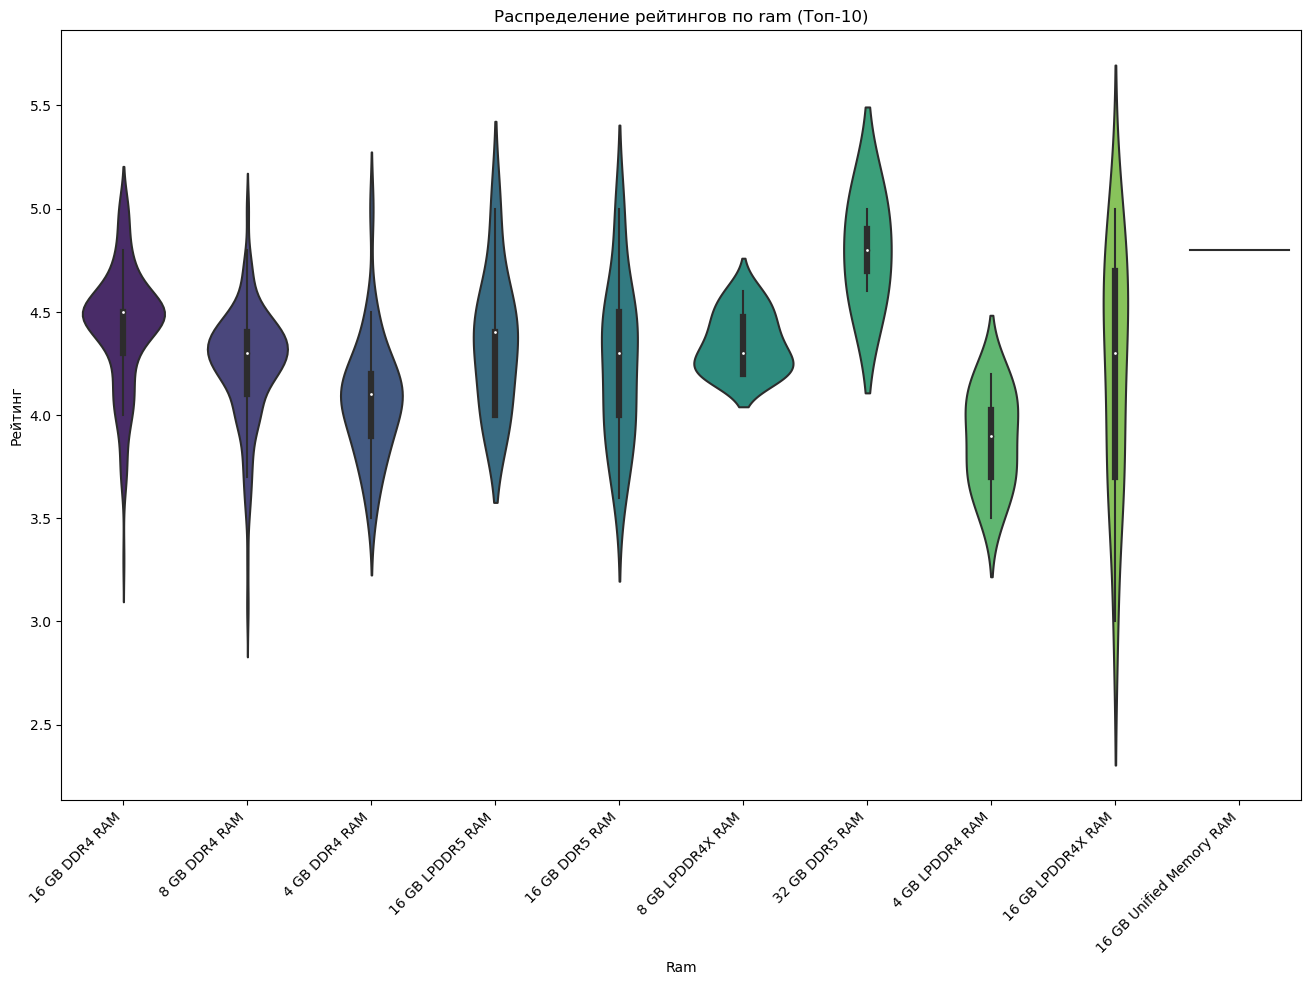

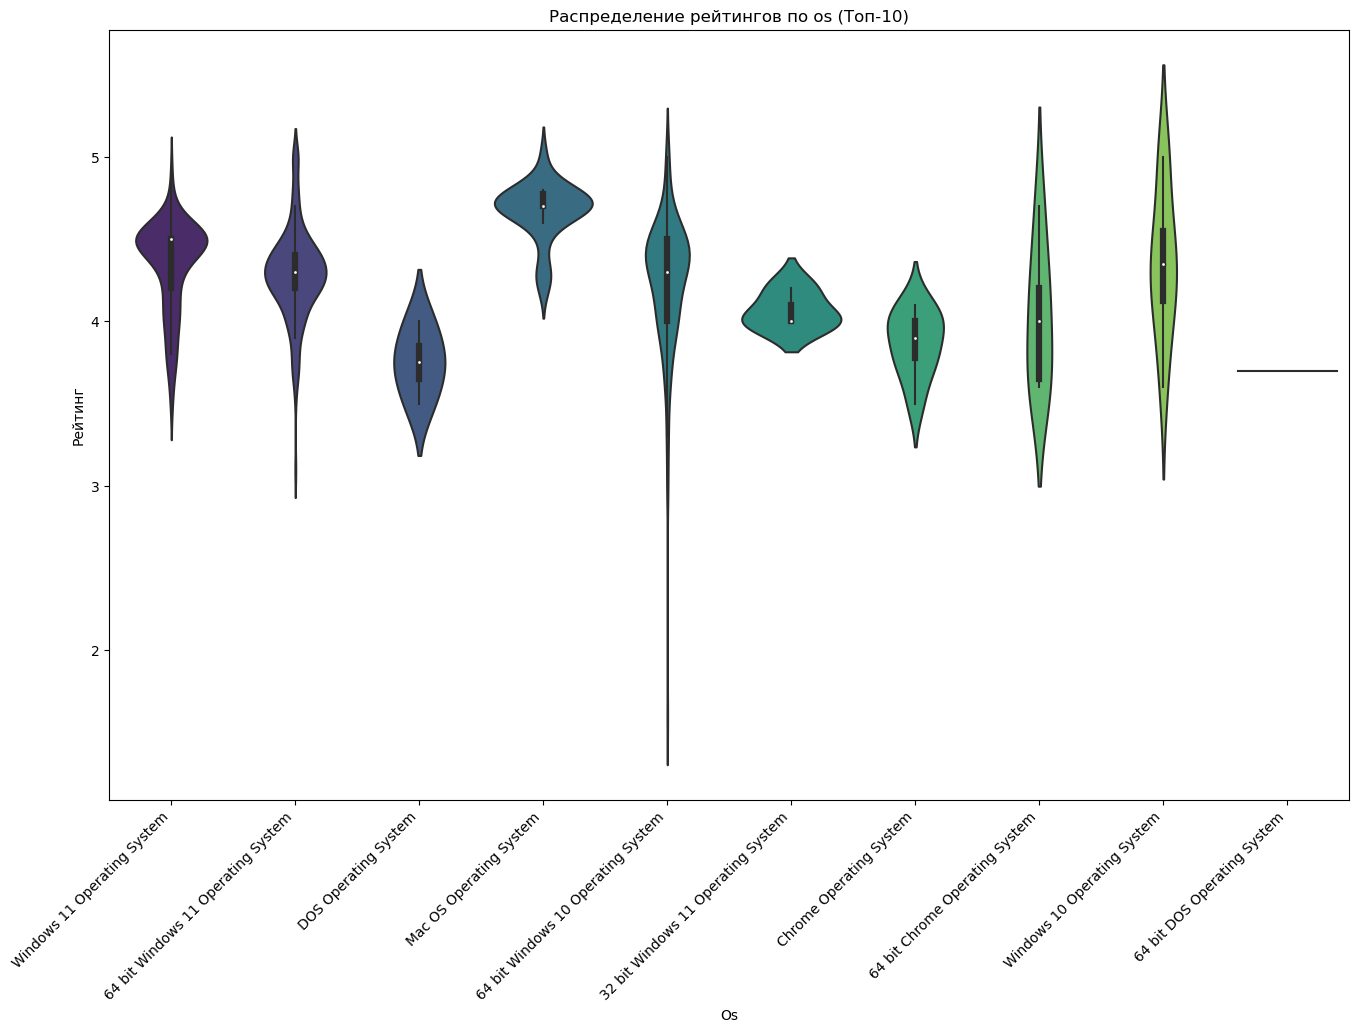

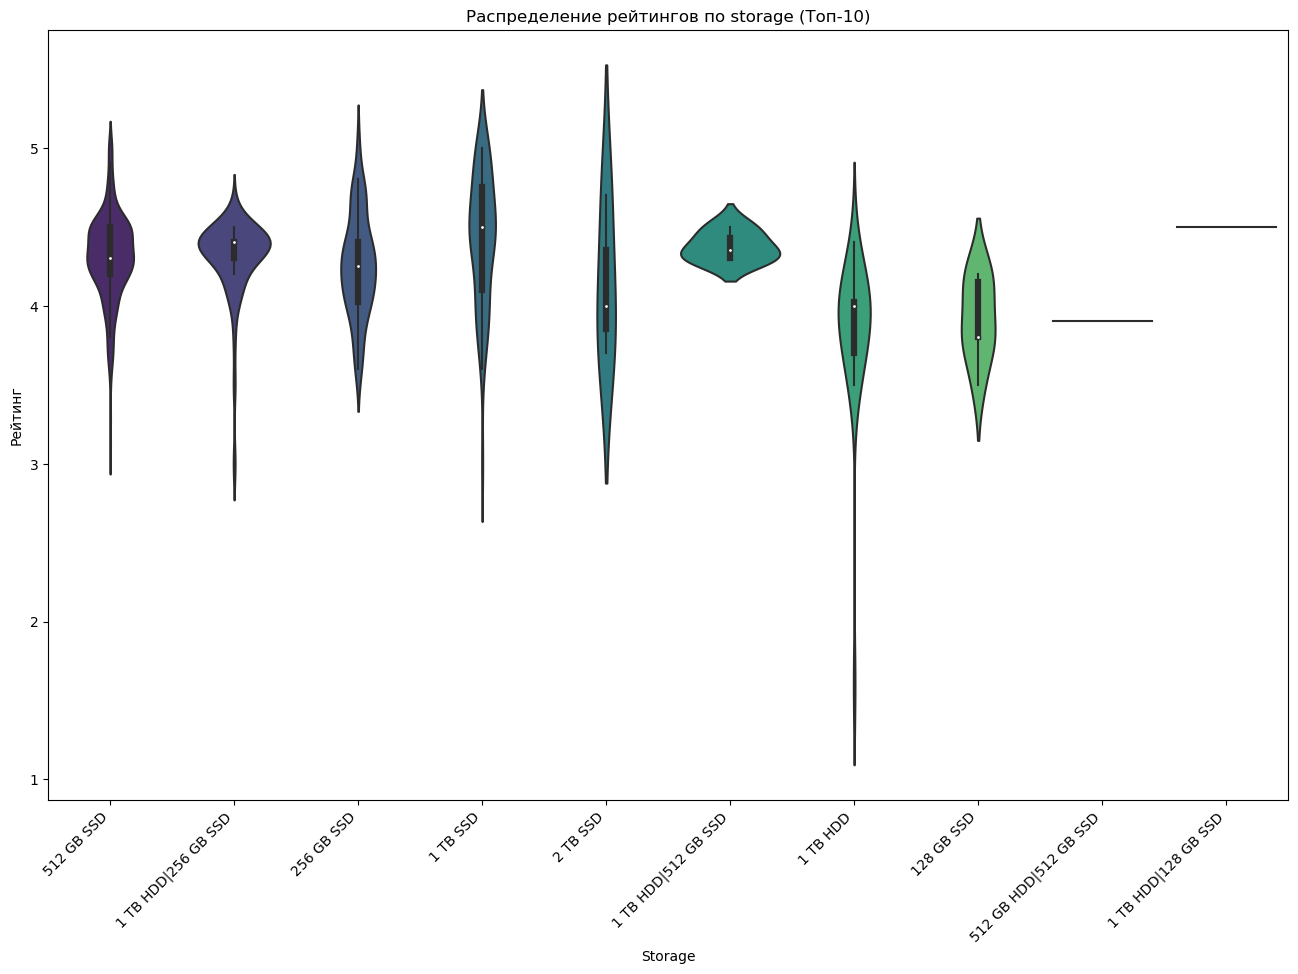

In [11]:
columns = ['processor', 'ram', 'os', 'storage']

for col in columns:
    top_10 = df[col].value_counts().head(10).index
    df_top_10 = df[df[col].isin(top_10)]

    plt.figure(figsize=(16, 10))
    sns.violinplot(x=col, y='rating', data=df_top_10, palette='viridis')

    plt.title(f'Распределение рейтингов по {col} (Топ-10)')
    plt.xlabel(col.capitalize())
    plt.ylabel('Рейтинг')
    plt.xticks(rotation=45, ha='right')
    plt.show()

**CPU:**
- Наиболее высокий средний рейтинг имеют ноутбуки на базе процессоров Core i5, Ryzen 5 и Ryzen 7. По форме виолин видно, что i5 и Ryzen 5 преимущественно стабильно получают оценки в районе 4,5, в то время как, например, ноутбуки на i7 получают весь спектр от 3 до 5. 
- Поколение у некоторых моделей не указано, остаётся лишь надеяться, что в таком случае подразумевается наиболее актуальное.<br><br>

**RAM:**
- Модели с 32Gb DDR5, очевидно, нравятся людям больше всего.
- В целом 16 и 8 тоже рабочие варианты.<br><br>

**OS:**
- MacOS имеет высшие оценки.
- В целом разброс по оценкам ОС чуть по меньше.
- Опять же вопрос, почему у нас есть Windows с подписанной разрядностью и без оной.<br><br>

**Storage:**
- 1Tb SSD или 1Tb HDD + 512/256 SSD выглядят как самые приятные комбинации.

Посмотрим на корреляцию цены и рейтинга.

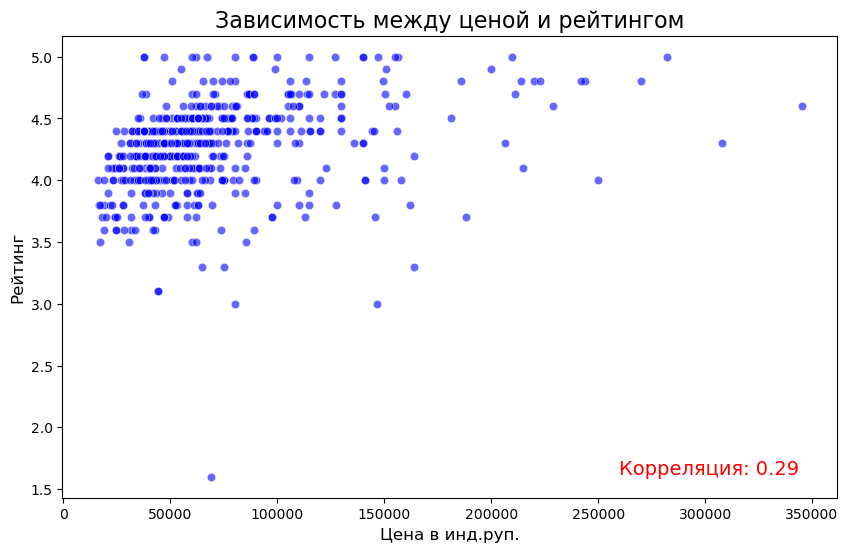

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='price(in Rs.)', 
    y='rating', 
    data=df, 
    color='blue', 
    alpha=0.6
)
plt.title('Зависимость между ценой и рейтингом', fontsize=16)
plt.xlabel('Цена в инд.руп.', fontsize=12)
plt.ylabel('Рейтинг', fontsize=12)

correlation = df[['price(in Rs.)', 'rating']].corr().iloc[0, 1]

plt.text(0.95, 0.05, 
         f'Корреляция: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=14, 
         color='red', 
         ha='right'
)
plt.show()

Корреляция положительная слабовыраженная. Низких оценок в датасете вообще почти нет, что в целом несколько затрудняет выявление зависимостей. Посмотрим на оценки по размеру экрана.

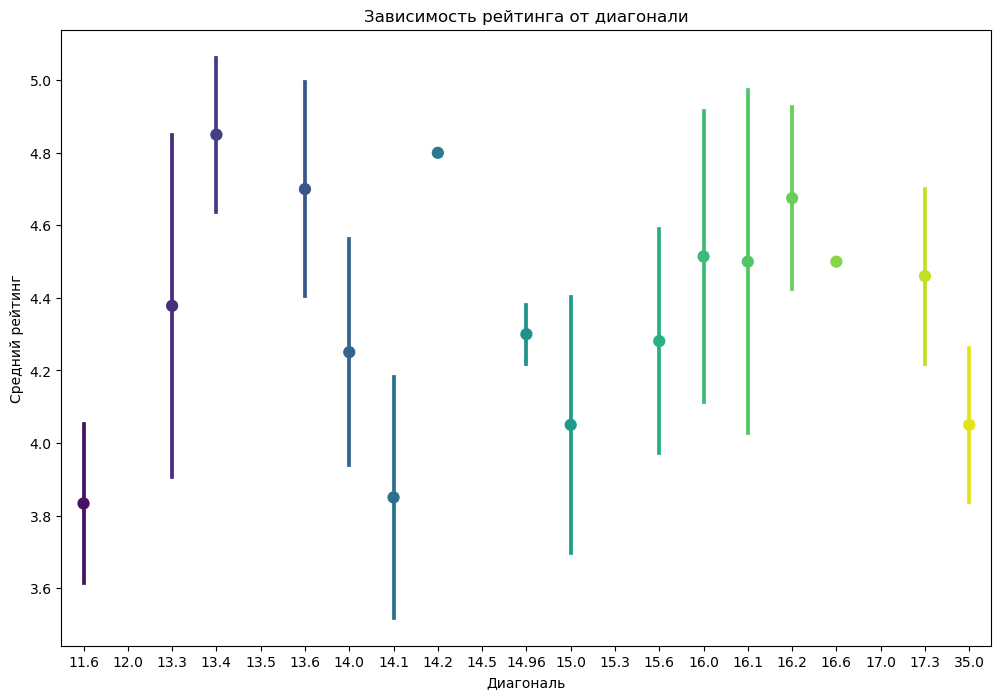

In [17]:
plt.figure(figsize=(12, 8))
sns.pointplot(
    data=df, 
    x='display(in inch)', 
    y='rating', 
    errorbar='sd', 
    palette='viridis'
)
plt.title('Зависимость рейтинга от диагонали')
plt.xlabel('Диагональ')
plt.ylabel('Средний рейтинг')
plt.show()

Как видим, высокие оценки у диагоналей, свойственных для макбуков, а так же диагональ 13,4 получает высокий средний балл.

## Финальный вывод

**В ходе работы были выявлены следующие недостатки в данных:**

- 30% бессистемных пропущенных значений в целевом признаке с рейтингом, что затрудняет выявление зависимостей.
- Нерегулярность в записи характеристик процессоров и других технических параметров, что указывает на проблему кривой недостаточно качественной сборки данных. <br><br>

**Оптимальная конфигурация**<br><br>
На основании имеющейся информации может быть предложена следующая конфигурация:
- CPU: Core i5 / Ryzen 5.
- RAM: 32/16 Gb DDR5
- OS: MacOS / Win11
- Storage: 1Tb SSD/1Tb HDD + 512/256 Gb SSD
- 13.4"